In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os

In [26]:
 # load data
dataDir = "D:/MHC/2022/개인자료/kmong/battery_health_등푸른비행선/tf to torch/PhyCNN/data/"
mat = scipy.io.loadmat(dataDir + 'data_exp.mat')

ag_data = mat['input_tf'][:, 0:2500]
u_data = mat['target_X_tf'][:, 0:2500, :]
ut_data = mat['target_Xd_tf'][:, 0:2500, :]
utt_data = mat['target_Xdd_tf'][:, 0:2500, :]
train_indices = mat['trainInd'] - 1
test_indices = mat['valInd'] - 1

ag_data = np.reshape(ag_data, [ag_data.shape[0], ag_data.shape[1], 1])

ag_train = ag_data
eta_train = u_data
eta_t_train = ut_data
eta_tt_train = utt_data

dt = 0.02

ag_all = ag_data
u_all = u_data
u_t_all = ut_data
u_tt_all = utt_data

# finite difference
n = u_data.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
Phi_t = 1 / dt * np.concatenate(
        [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)

ag_star = ag_all
eta_star = u_all
eta_t_star = u_t_all
eta_tt_star = u_tt_all
g_star = -eta_tt_star -ag_star
lift_star = -ag_star

N_train = eta_star.shape[0]

eta = eta_star
ag = ag_star
lift = lift_star
eta_t = eta_t_star
eta_tt = eta_tt_star
g = g_star

# Training Data
eta_train = eta
ag_train = ag
lift_train = lift
eta_t_train = eta_t
eta_tt_train = eta_tt
g_train = g

In [27]:
class CNN(nn.Module):
    def __init__(self, input_size, feature_size, numout):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=50, stride=1, padding=25),
            nn.ReLU()
        )

        # n_channels = self.conv(torch.empty(1, input_size, feature_size)).size(-1)
        self.output_layer = nn.Sequential(nn.Linear(64, 50),
                                          nn.ReLU(),
                                          nn.Linear(50, 50),
                                          nn.ReLU(),
                                          nn.Linear(50, numout))

    def forward(self, x_in):
        x = x_in.permute(0, 2, 1)
        x = self.conv(x)
        x = x[:, :, :2500]
        x = x.permute(0, 2, 1)
        out = self.output_layer(x)# (15, 2500, 2) 출력 형태로 변환
        return out

In [28]:
eta_tt, ag, Phi_t =eta_tt_train, ag_train, Phi_t

learning_rate = 0.001 # 초기 학습률 지정
eta_tt_torch = torch.from_numpy(eta_tt).float()
ag_torch = torch.from_numpy(ag).float()

model = CNN(input_size=1, feature_size=ag.shape[-1], numout=eta_tt.shape[2])
eta_tt_torch.requires_grad = True
ag_torch.requires_grad = True

optimizer_Adam = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
# init net_structure
eta_pred = model(ag_torch)
Phi_ut = Phi_t.reshape(1, eta_tt.shape[1], eta_tt.shape[1])
Phi_ut = Phi_ut.repeat(eta_tt.shape[0], axis=0)

eta_t_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_pred)

eta_tt_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_t_pred)

In [30]:
# train model
num_epochs = 50
bfgs=True
batch_size=N_train

model.train()
Loss = []
for epoch in range(num_epochs):
    N = eta_tt.shape[0]
    for it in range(0, N, batch_size):
        optimizer_Adam.zero_grad()

        eta_pred = model(ag_torch)
        Phi_ut = Phi_t.reshape(1, eta_tt.shape[1], eta_tt.shape[1])
        Phi_ut = Phi_ut.repeat(eta_tt.shape[0], axis=0)
                
        eta_t_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_pred)
        eta_tt_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_t_pred)

        loss = torch.mean(torch.square(eta_tt_torch - eta_tt_pred)) + torch.mean(torch.square(eta_pred[:,:,0:10]))
        loss.backward()
        optimizer_Adam.step()
        if it % (10*batch_size) == 0:
                print('Epoch: %d, It: %d, Loss: %.3e,  Learning Rate: %.3e'
                    %(epoch, it/batch_size, loss.item(), learning_rate))

    Loss.append(loss.item())


if bfgs:
    # use L-BFGS optimizer
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=learning_rate, 
                                  max_iter=10, max_eval=50000, history_size=50, line_search_fn='strong_wolfe')
    def closure():
        optimizer_lbfgs.zero_grad()

        eta_pred = model(ag_torch)
        Phi_ut = Phi_t.reshape(1, eta_tt.shape[1], eta_tt.shape[1])
        Phi_ut = Phi_ut.repeat(eta_tt.shape[0], axis=0)
                
        eta_t_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_pred)
        eta_tt_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_t_pred)
        
        loss = torch.mean(torch.square(eta_tt_torch - eta_tt_pred)) + torch.mean(torch.square(eta_pred[:,:,0:10]))
        loss.backward()
        return loss

    optimizer_lbfgs.step(closure)

    lbfgs_loss = torch.mean(torch.square(eta_tt_torch - eta_tt_pred)) + torch.mean(torch.square(eta_pred[:,:,0:10]))

    print('LBFGS Loss :', lbfgs_loss.item())
    Loss.append(lbfgs_loss.item())

Epoch: 0, It: 0, Loss: 2.249e+01,  Learning Rate: 1.000e-03
Epoch: 1, It: 0, Loss: 2.247e+01,  Learning Rate: 1.000e-03
Epoch: 2, It: 0, Loss: 2.240e+01,  Learning Rate: 1.000e-03
Epoch: 3, It: 0, Loss: 2.199e+01,  Learning Rate: 1.000e-03
Epoch: 4, It: 0, Loss: 2.058e+01,  Learning Rate: 1.000e-03
Epoch: 5, It: 0, Loss: 1.884e+01,  Learning Rate: 1.000e-03
Epoch: 6, It: 0, Loss: 1.690e+01,  Learning Rate: 1.000e-03
Epoch: 7, It: 0, Loss: 1.563e+01,  Learning Rate: 1.000e-03
Epoch: 8, It: 0, Loss: 1.430e+01,  Learning Rate: 1.000e-03
Epoch: 9, It: 0, Loss: 1.364e+01,  Learning Rate: 1.000e-03
Epoch: 10, It: 0, Loss: 1.265e+01,  Learning Rate: 1.000e-03
Epoch: 11, It: 0, Loss: 1.173e+01,  Learning Rate: 1.000e-03
Epoch: 12, It: 0, Loss: 1.047e+01,  Learning Rate: 1.000e-03
Epoch: 13, It: 0, Loss: 9.066e+00,  Learning Rate: 1.000e-03
Epoch: 14, It: 0, Loss: 8.197e+00,  Learning Rate: 1.000e-03
Epoch: 15, It: 0, Loss: 7.923e+00,  Learning Rate: 1.000e-03
Epoch: 16, It: 0, Loss: 7.414e+00,

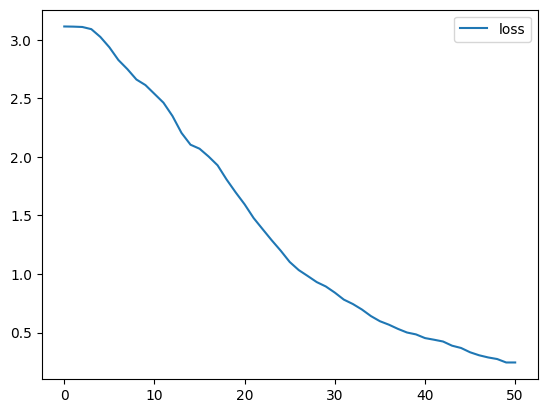

In [31]:
train_loss = Loss

plt.figure()
plt.plot(np.log(train_loss), label='loss')
plt.legend()

In [32]:
X_train = ag_train
y_train_ref = eta_train
yt_train_ref = eta_t_train
ytt_train_ref = eta_tt_train

In [33]:
ag_test_torch = torch.from_numpy(X_train).float()
ag_test_torch.requires_grad = True

model.eval()

eta_pred = model(ag_test_torch)
Phi_ut = Phi_t.reshape(1, eta_tt.shape[1], eta_tt.shape[1])
Phi_ut = Phi_ut.repeat(eta_tt.shape[0], axis=0)
                
eta_t_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_pred)
eta_tt_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_t_pred)

eta_pred = eta_pred.detach().numpy()
eta_t_pred = eta_t_pred.detach().numpy()
eta_tt_pred = eta_tt_pred.detach().numpy()

y_train_pred, yt_train_pred, ytt_train_pred = eta_pred, eta_t_pred, eta_tt_pred

d:\MHC\2023\ds_venv\ds_edu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


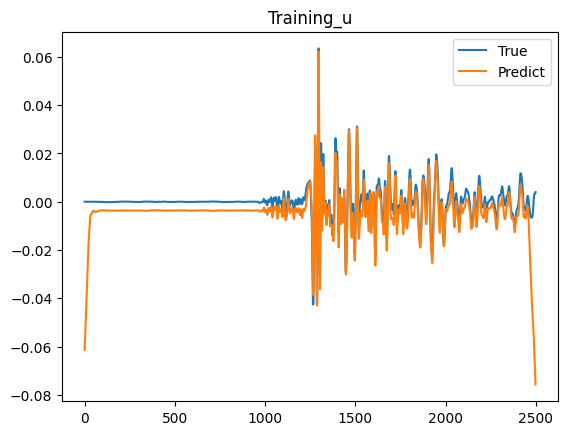

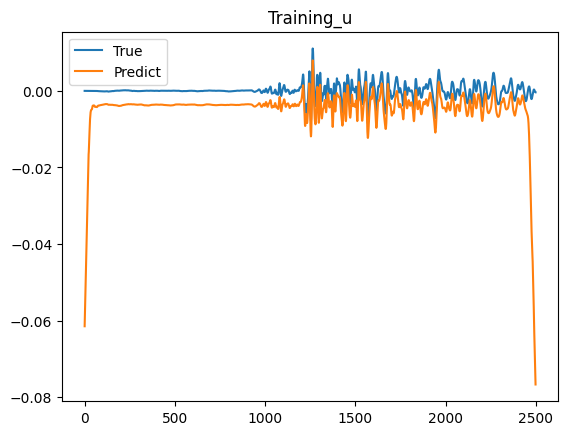

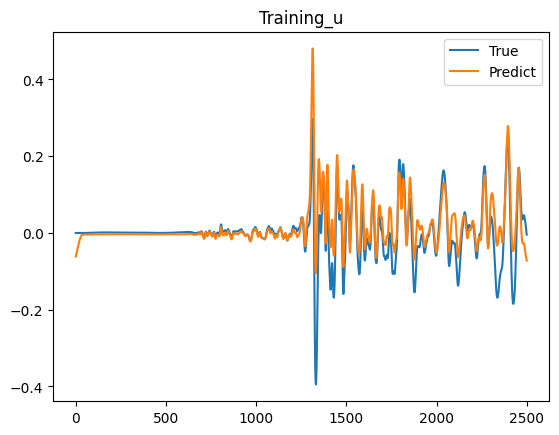

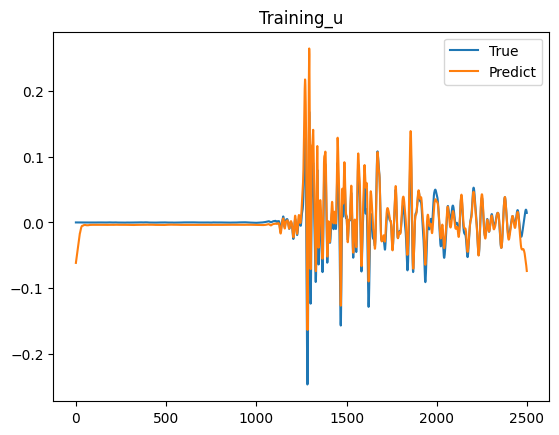

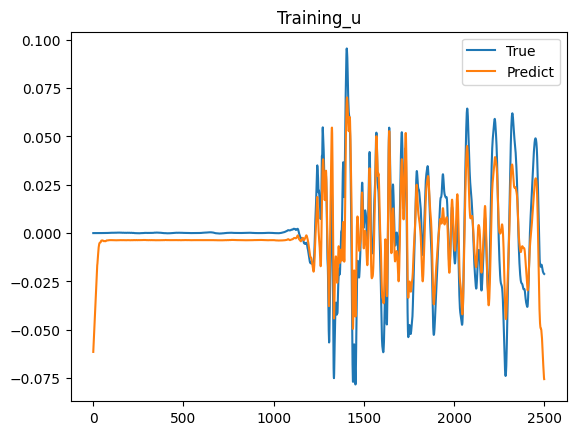

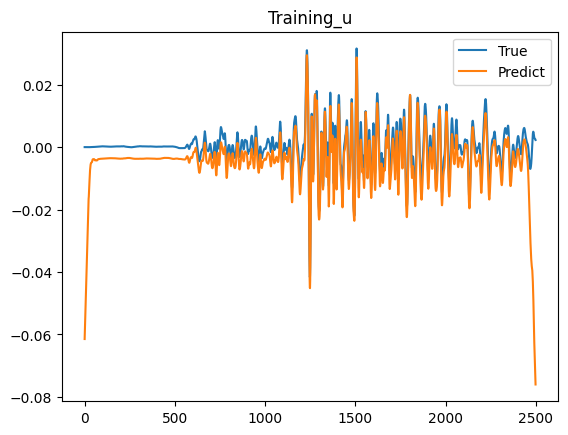

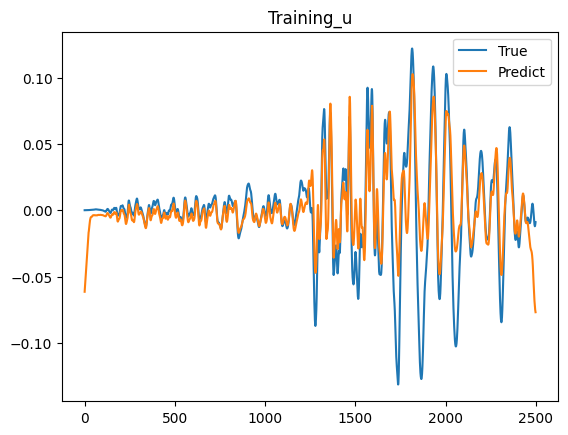

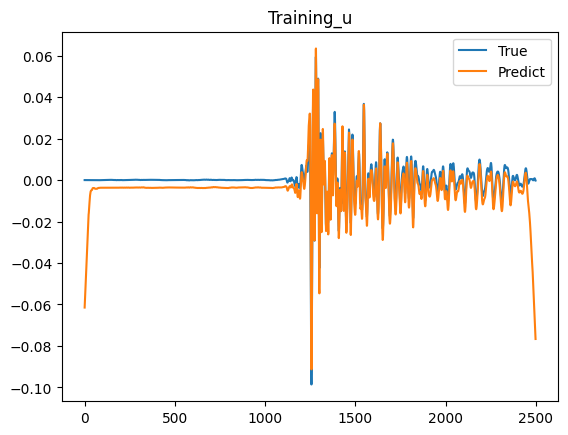

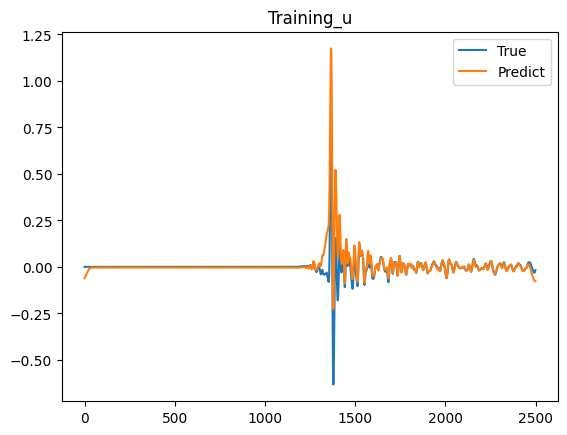

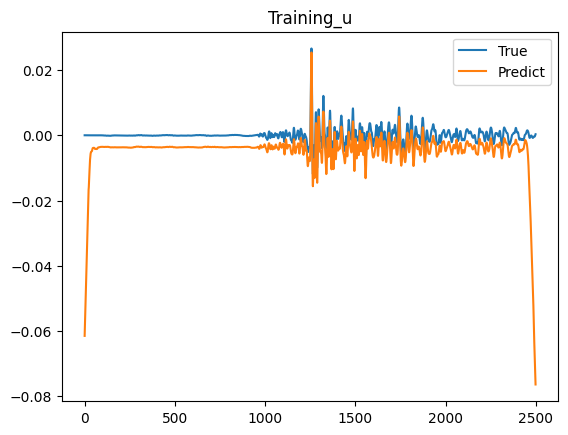

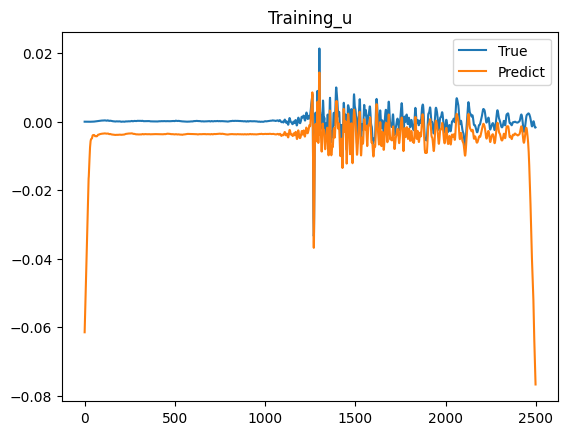

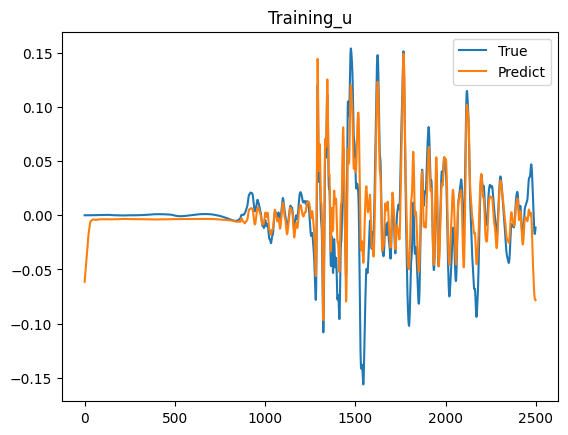

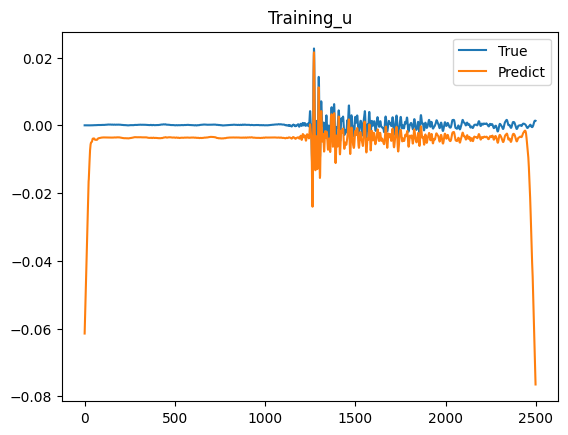

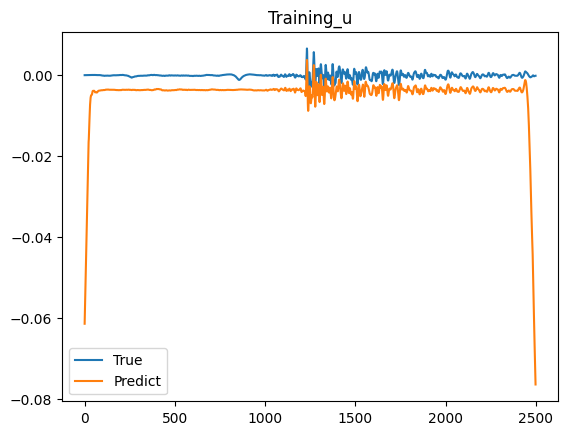

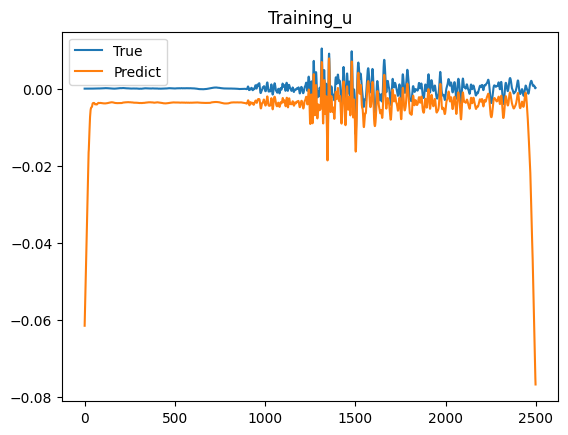

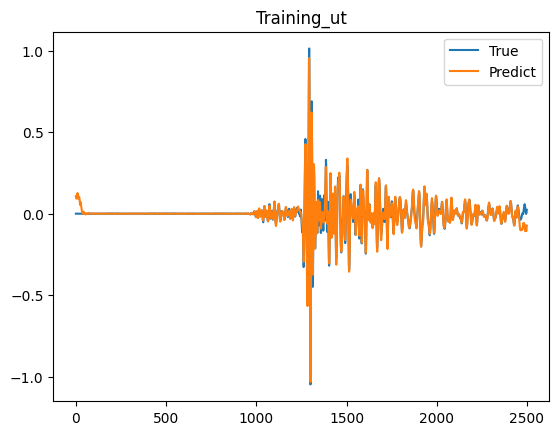

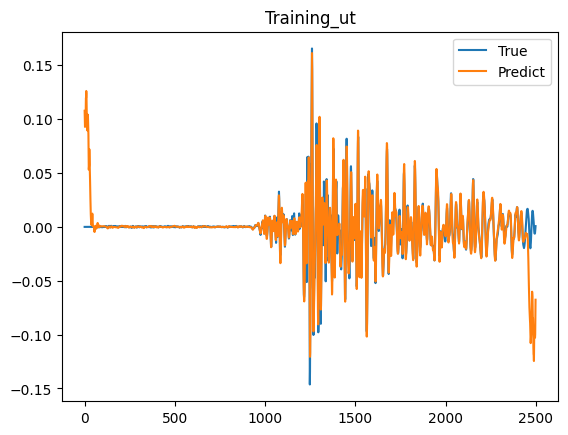

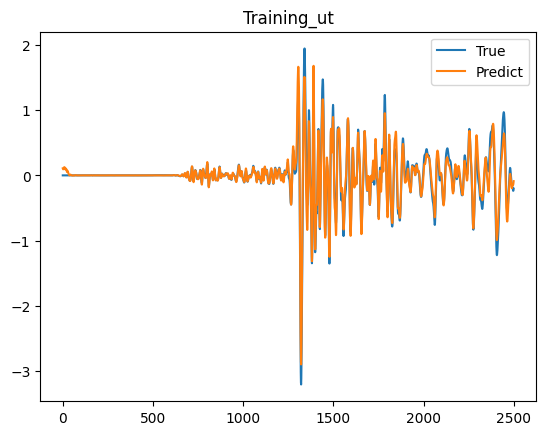

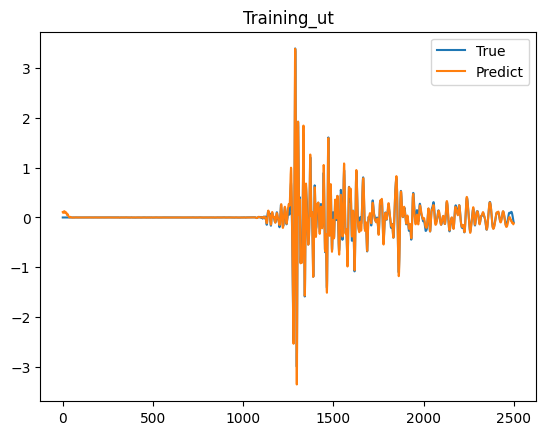

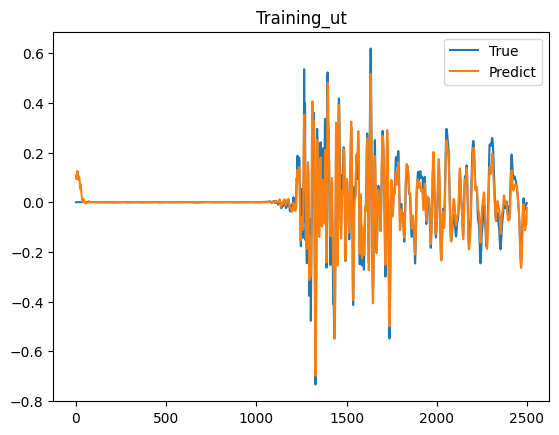

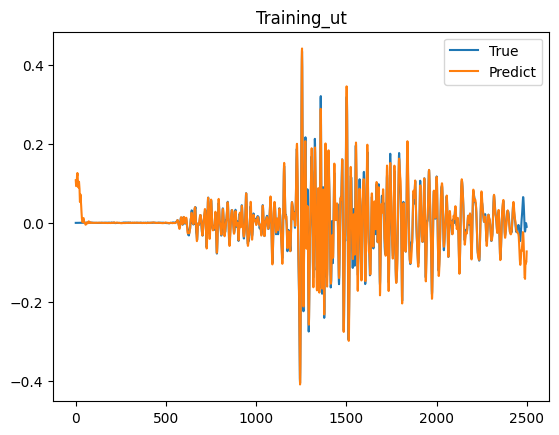

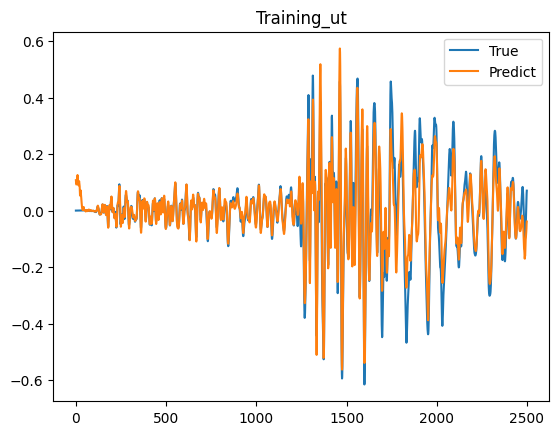

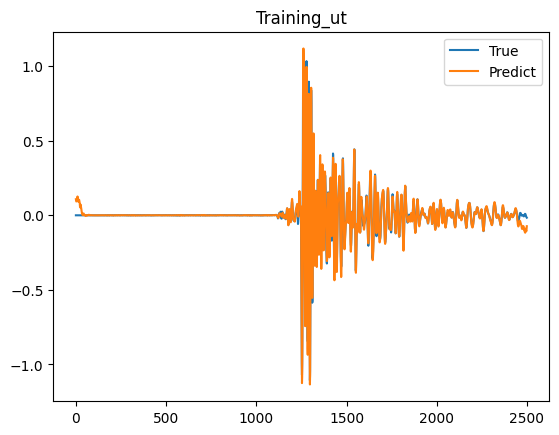

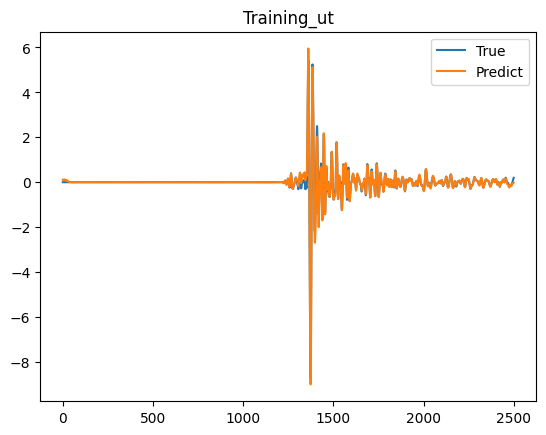

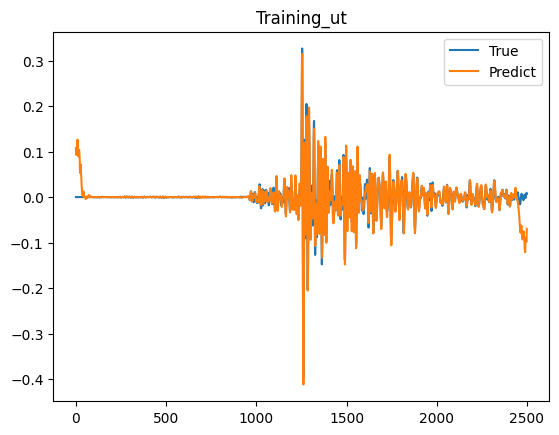

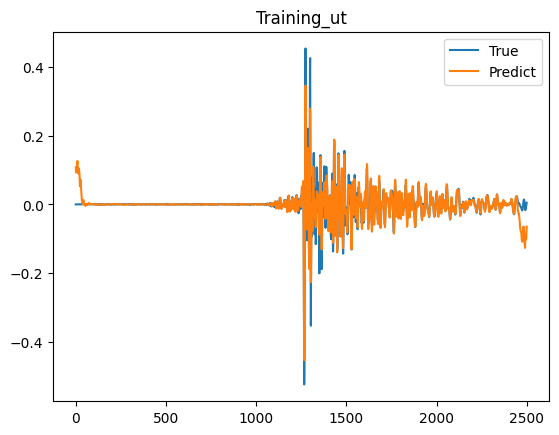

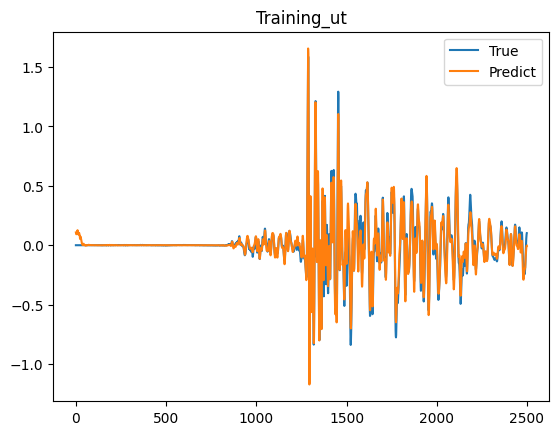

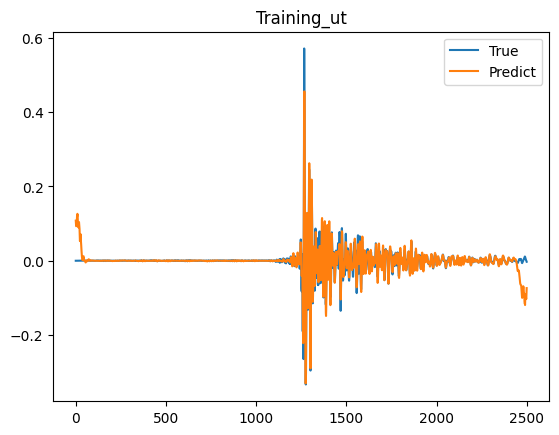

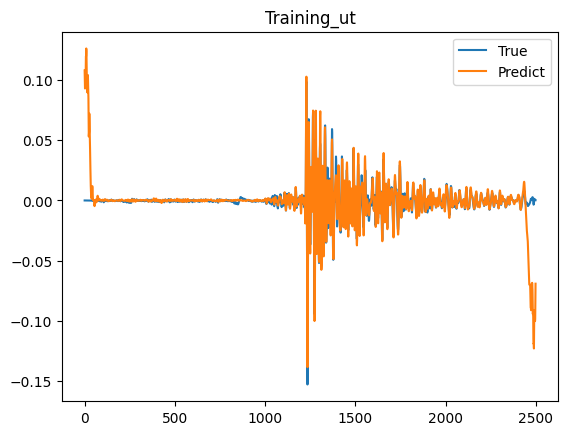

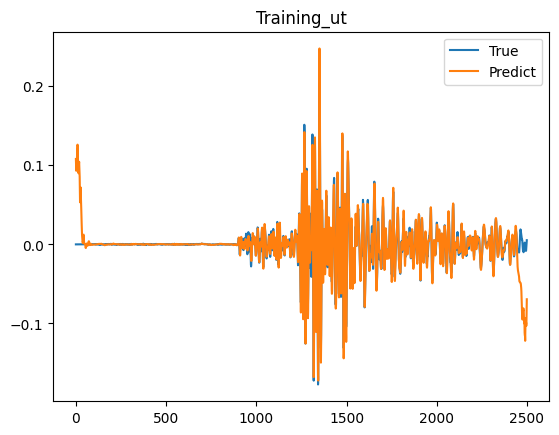

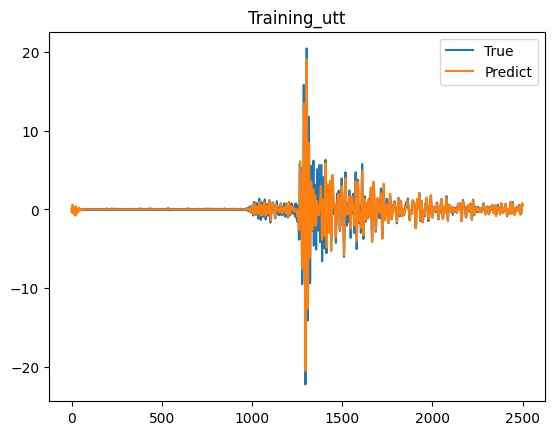

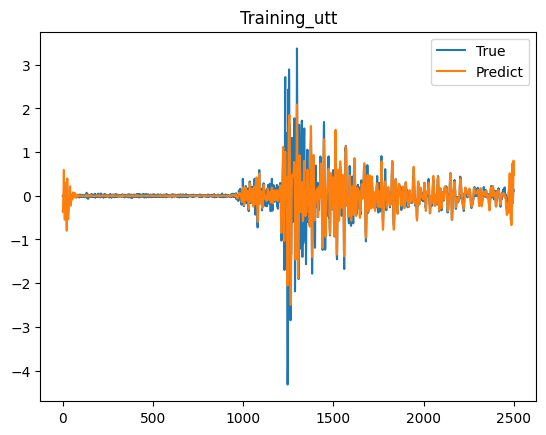

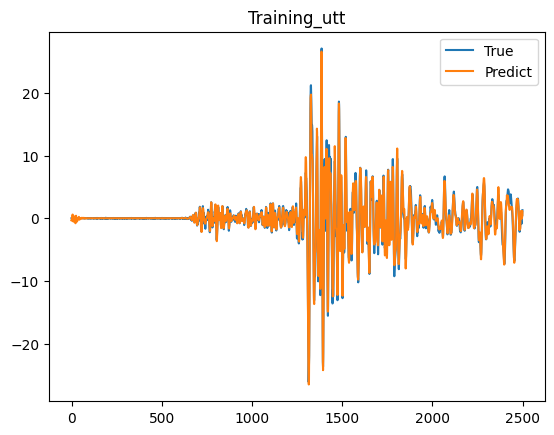

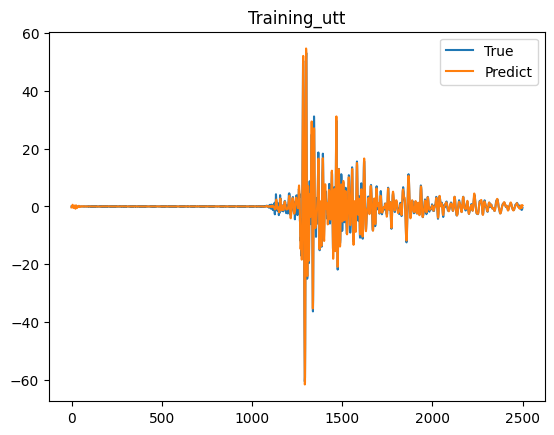

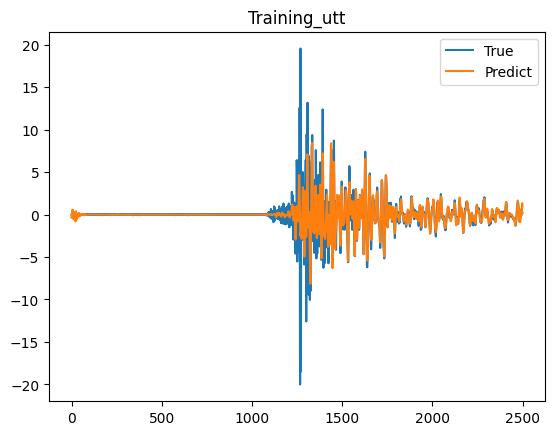

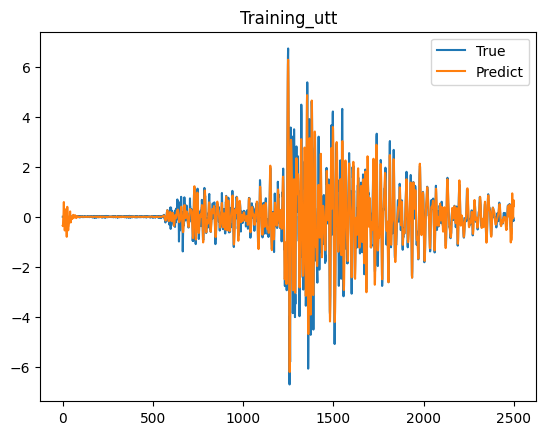

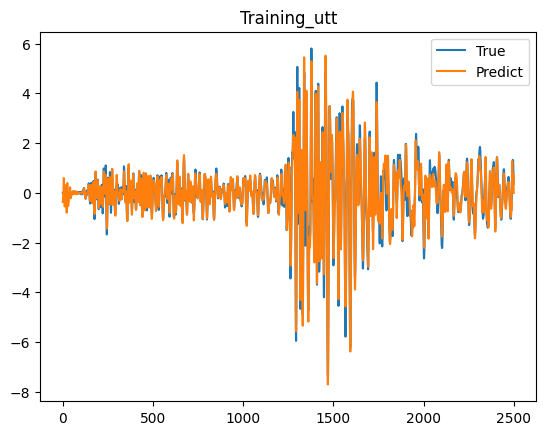

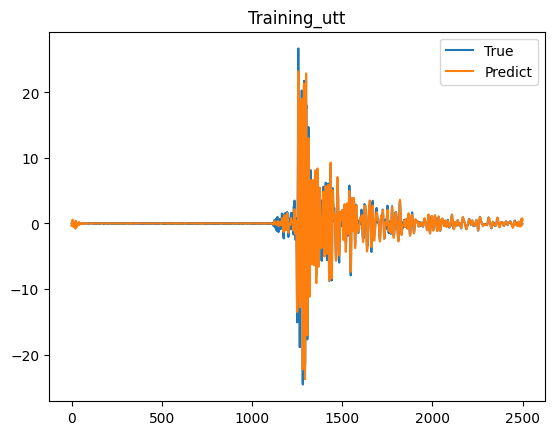

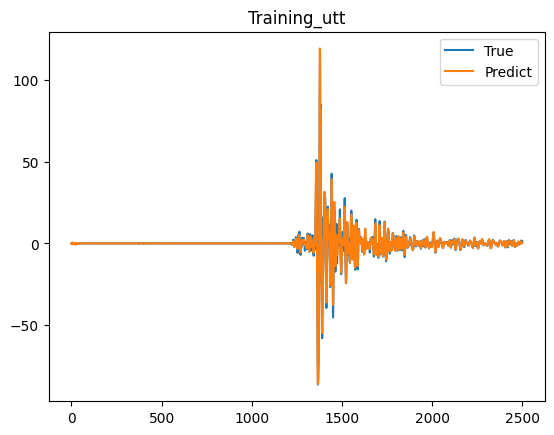

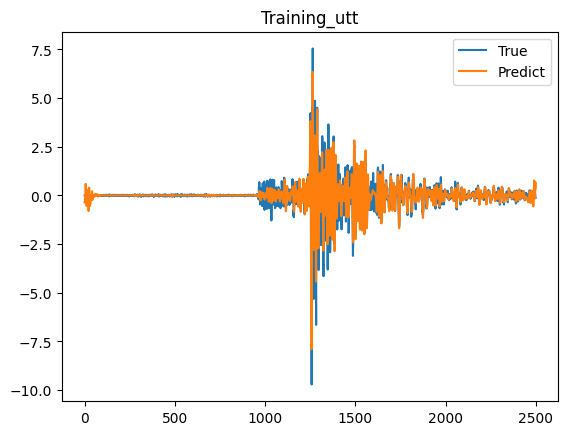

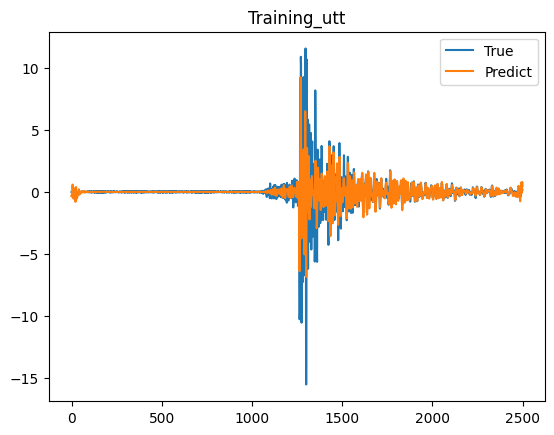

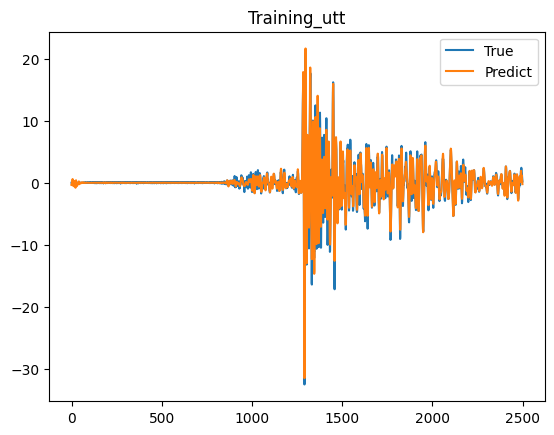

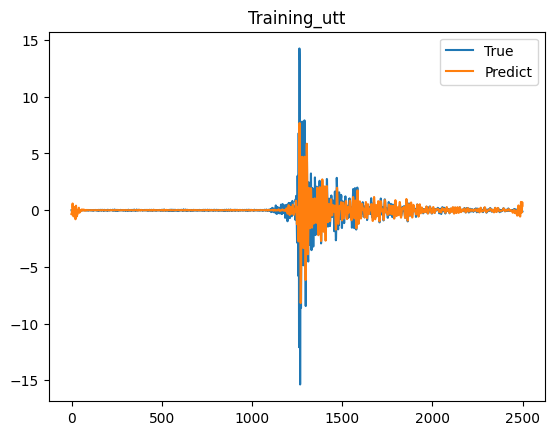

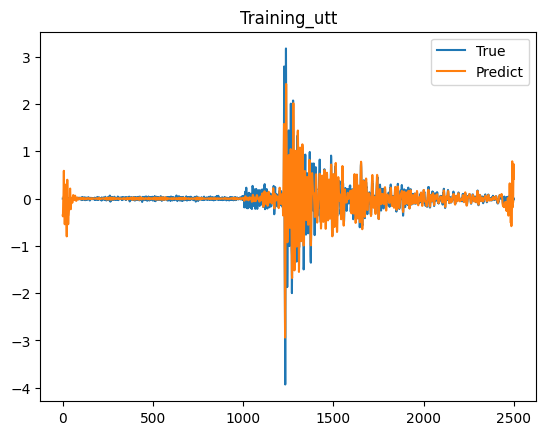

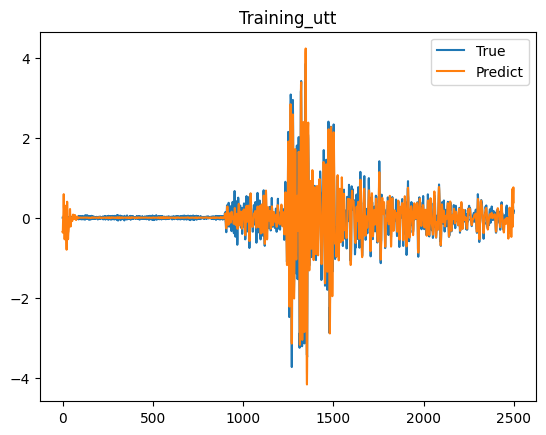

In [34]:
dof = 0
for n in range(len(ag_star)):
    plt.figure()
    plt.plot(y_train_ref[n, :, dof], label='True')
    plt.plot(y_train_pred[n, :, dof], label='Predict')
    plt.title('Training_u')
    plt.legend()

for n in range(len(ag_star)):
    plt.figure()
    plt.plot(yt_train_ref[n, :, dof], label='True')
    plt.plot(yt_train_pred[n, :, dof], label='Predict')
    plt.title('Training_ut')
    plt.legend()

for n in range(len(ag_star)):
    plt.figure()
    plt.plot(ytt_train_ref[n, :, dof], label='True')
    plt.plot(ytt_train_pred[n, :, dof], label='Predict')
    plt.title('Training_utt')
    plt.legend()

d:\MHC\2023\ds_venv\ds_edu\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


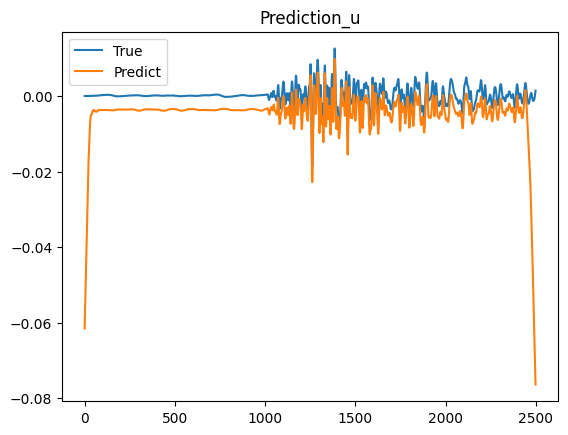

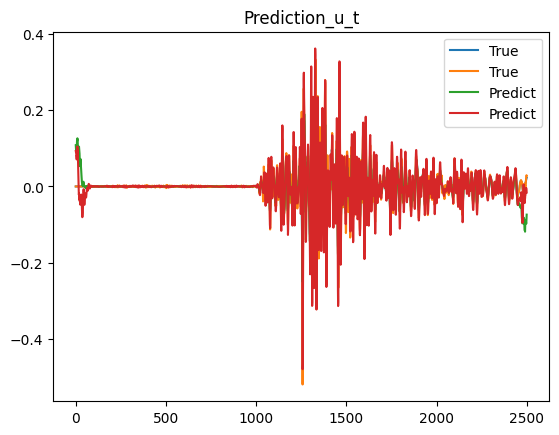

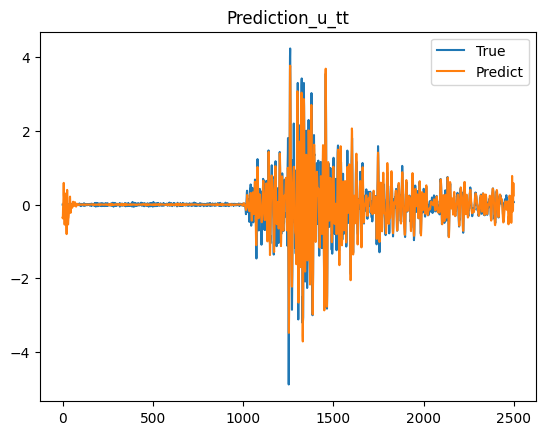

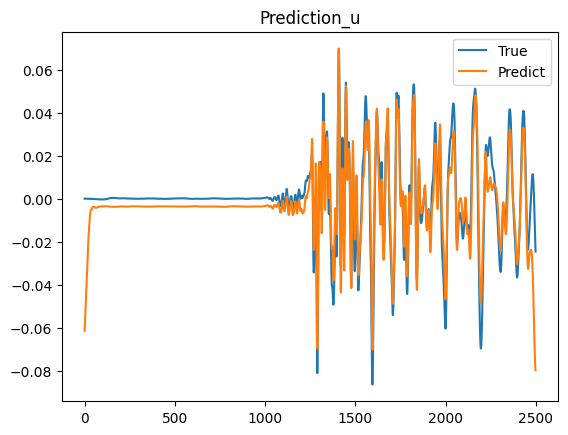

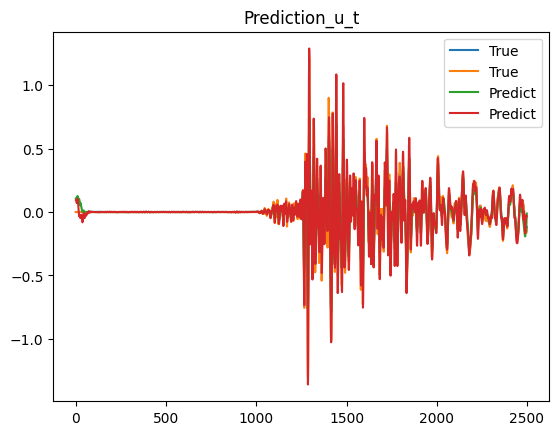

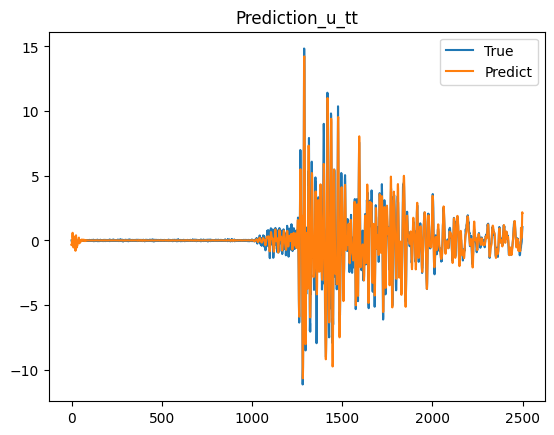

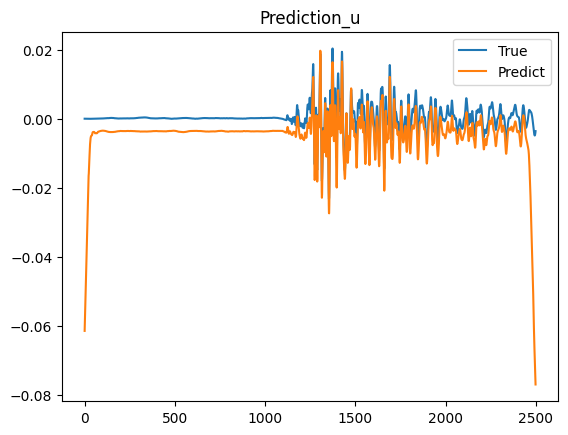

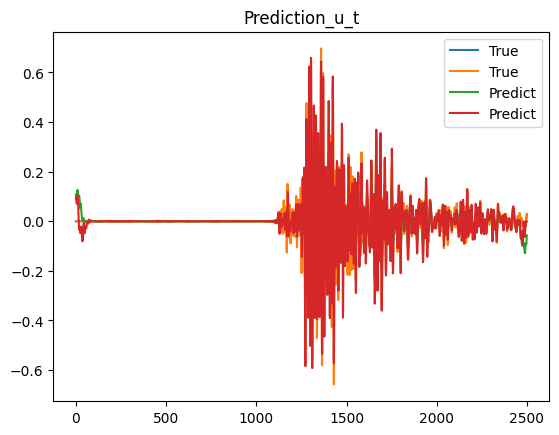

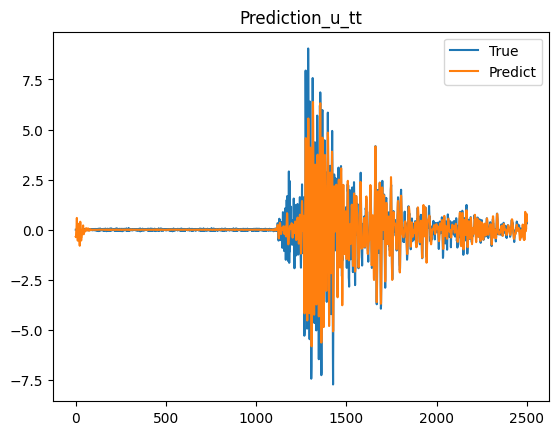

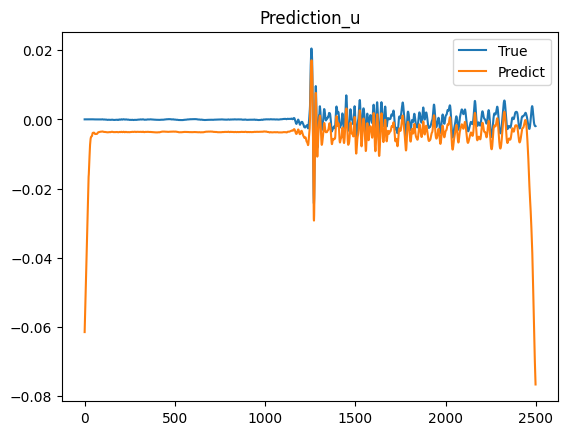

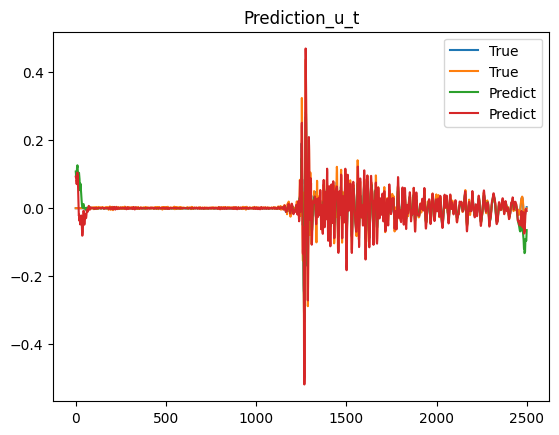

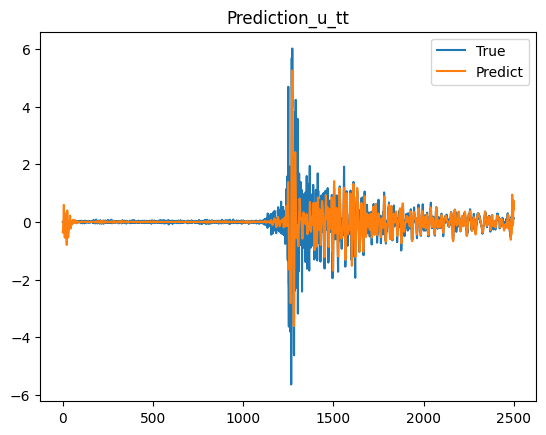

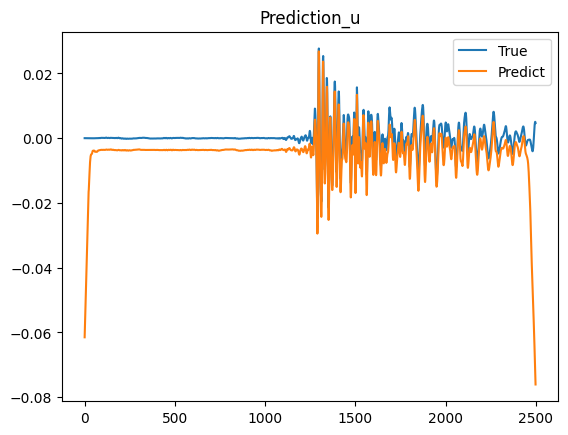

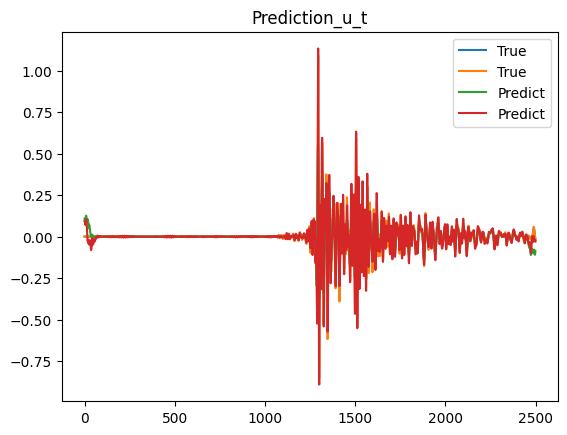

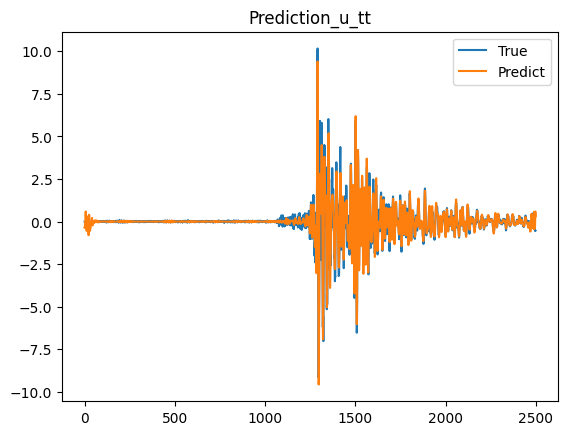

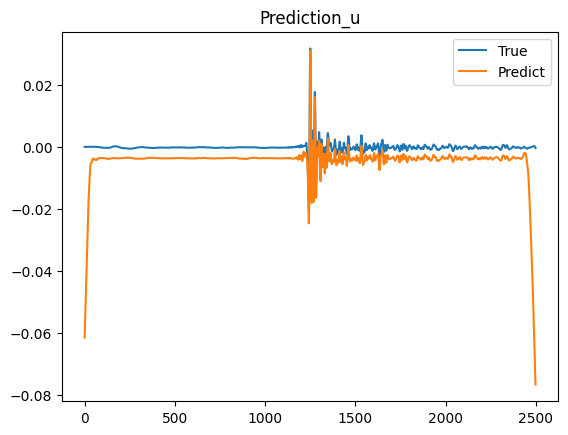

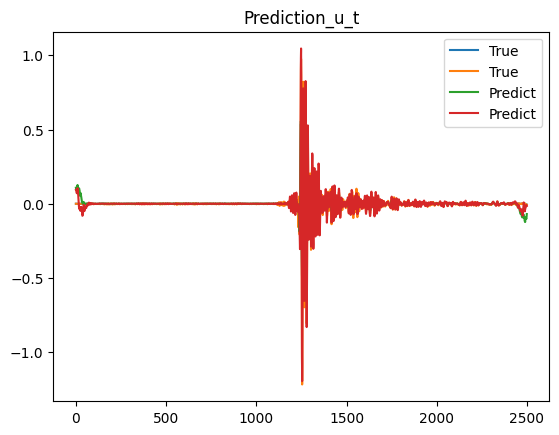

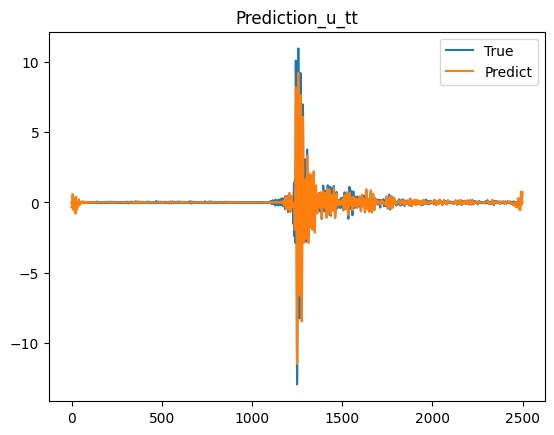

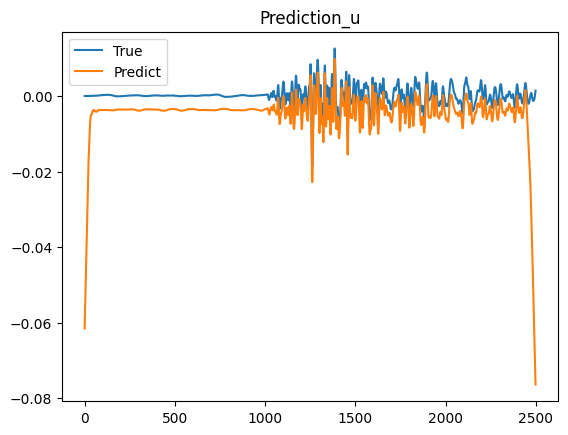

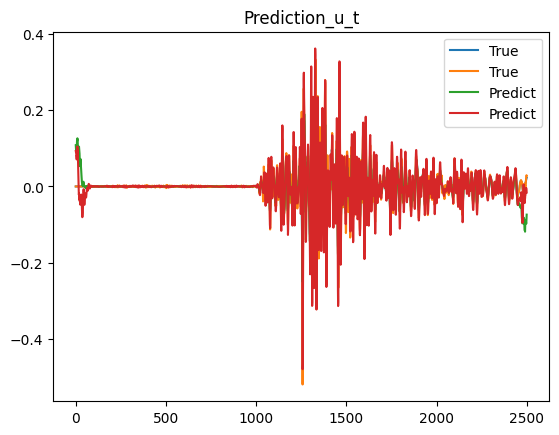

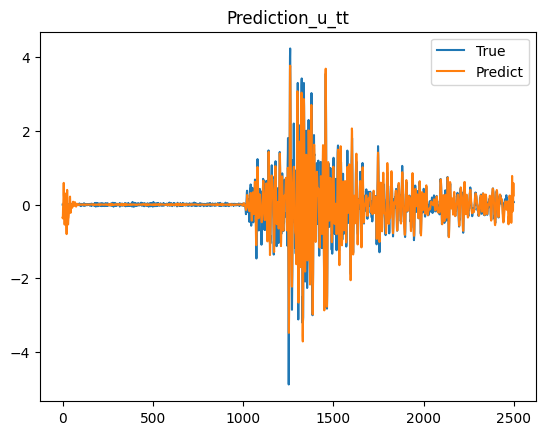

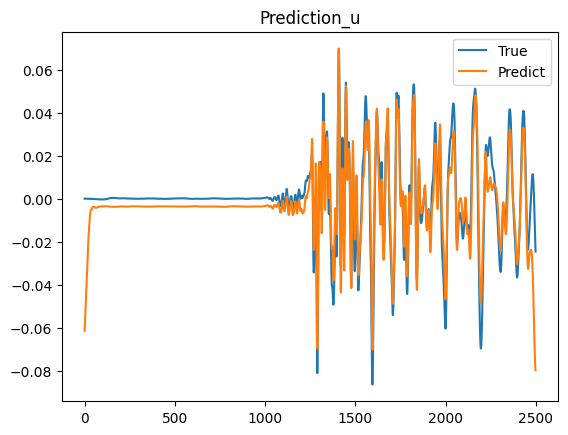

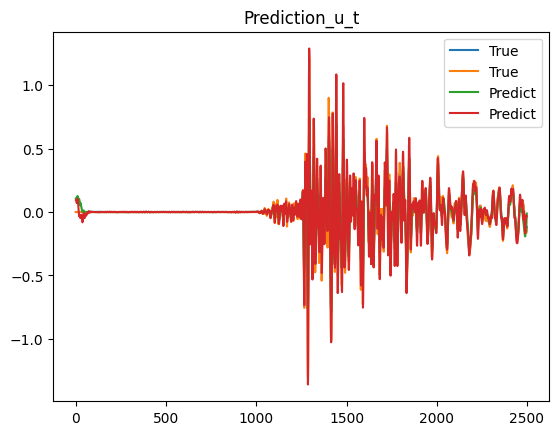

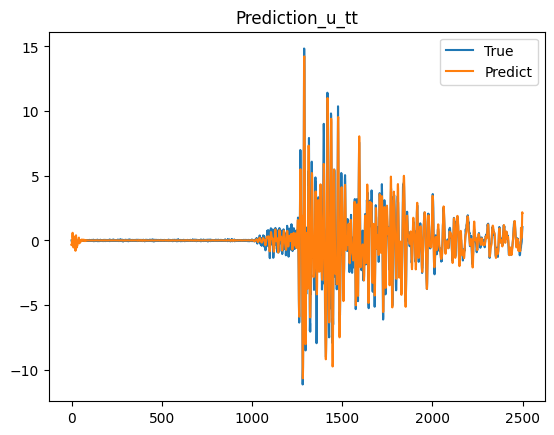

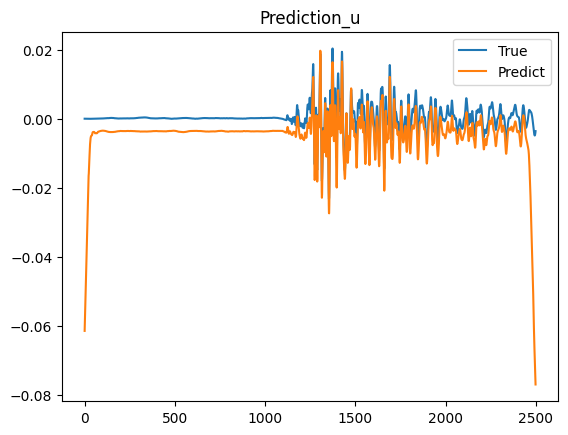

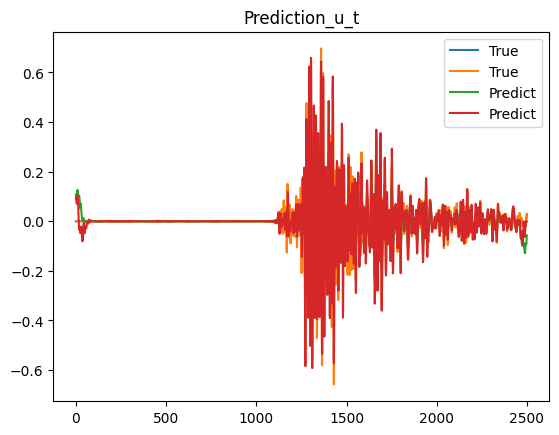

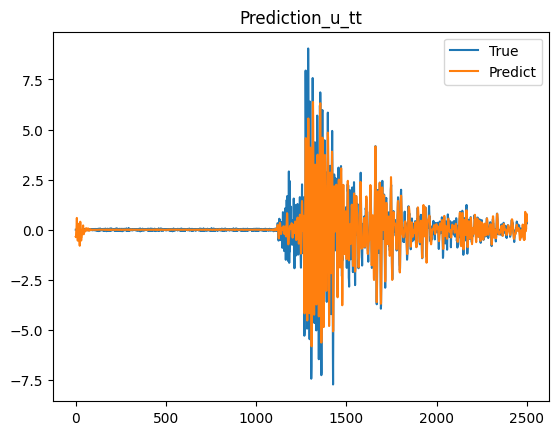

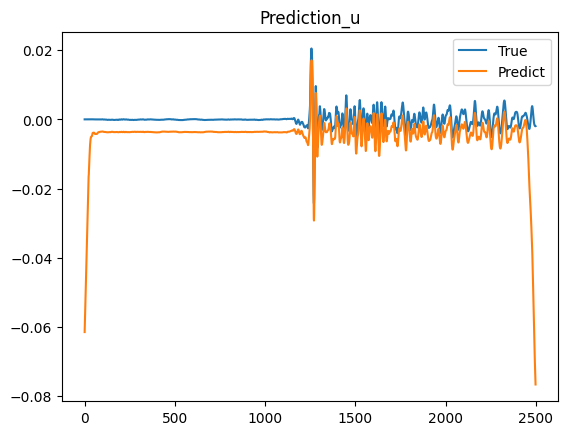

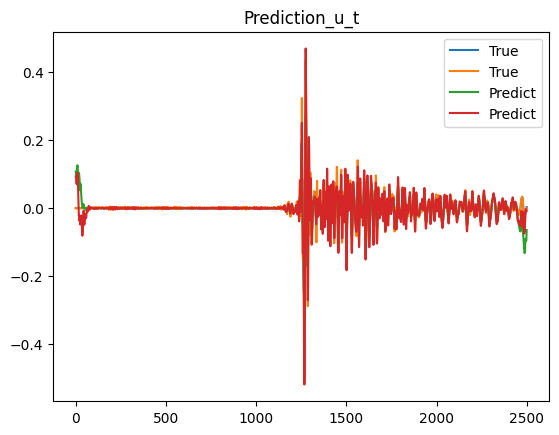

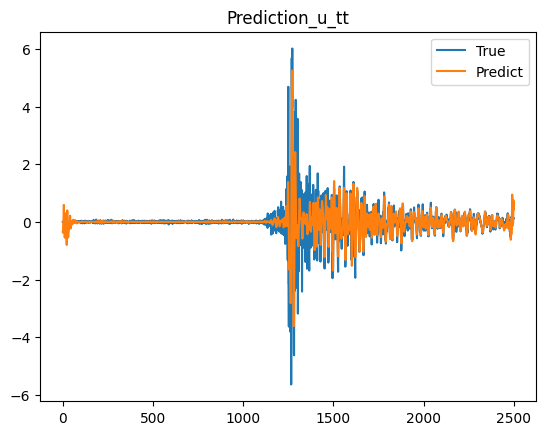

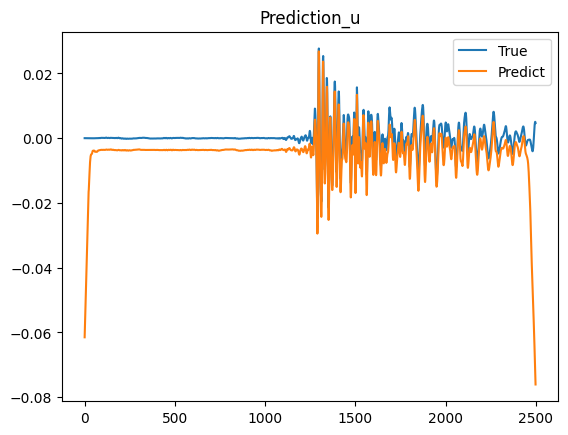

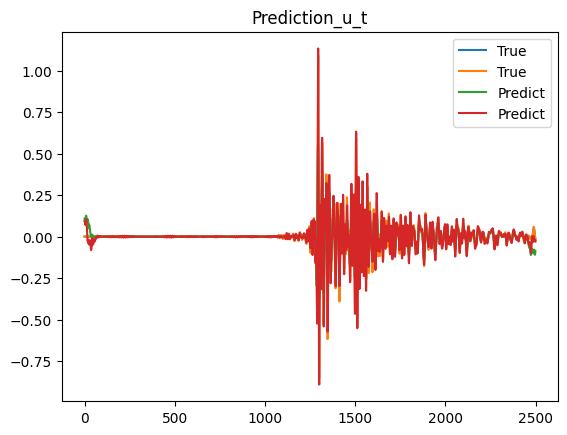

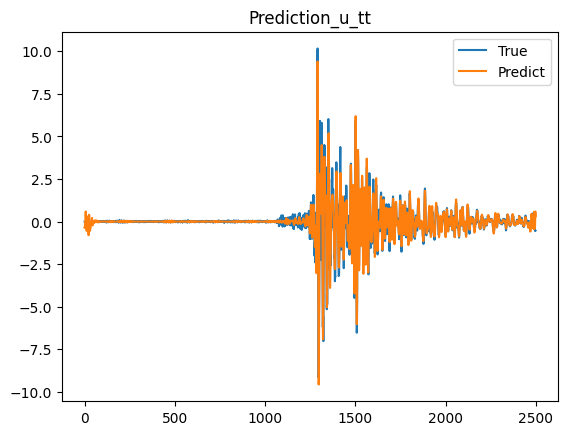

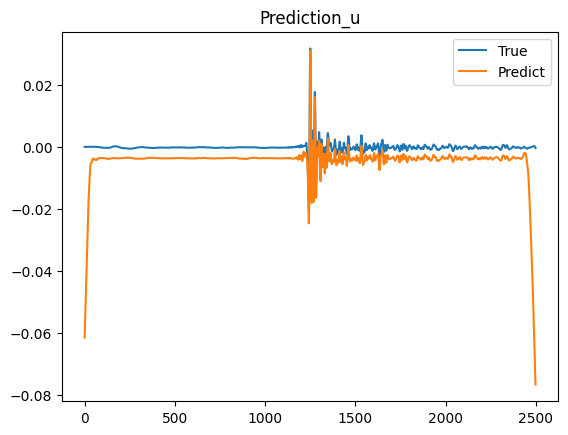

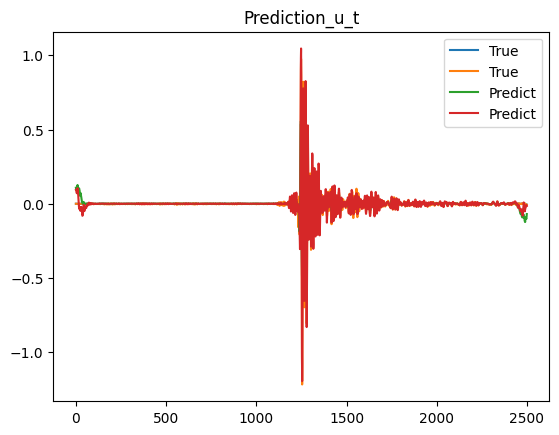

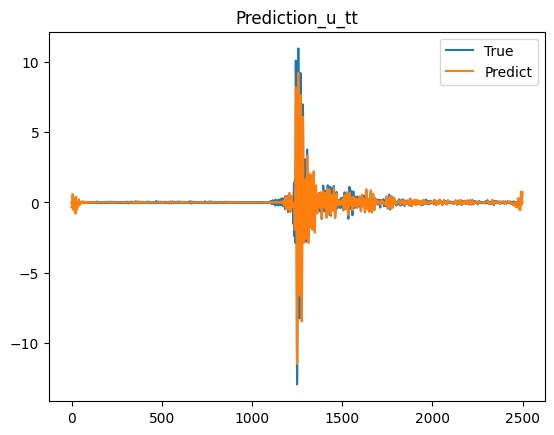

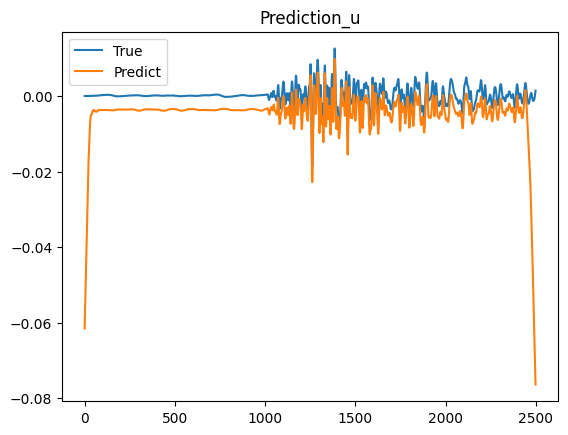

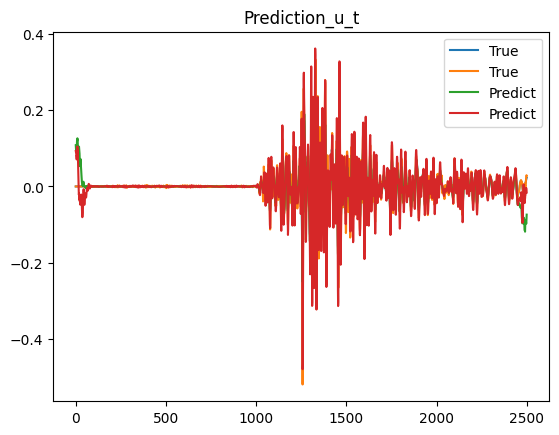

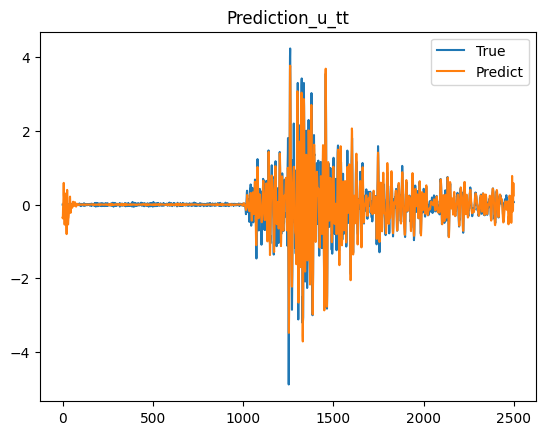

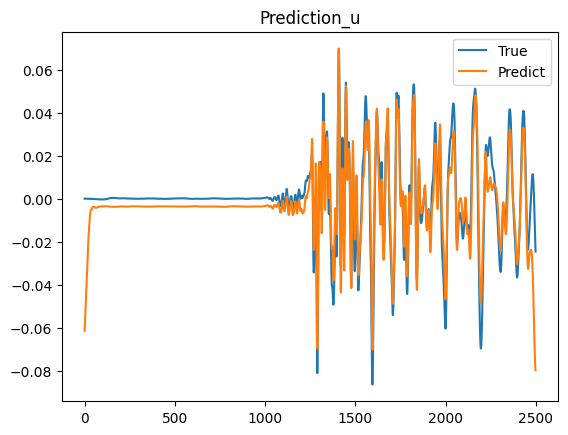

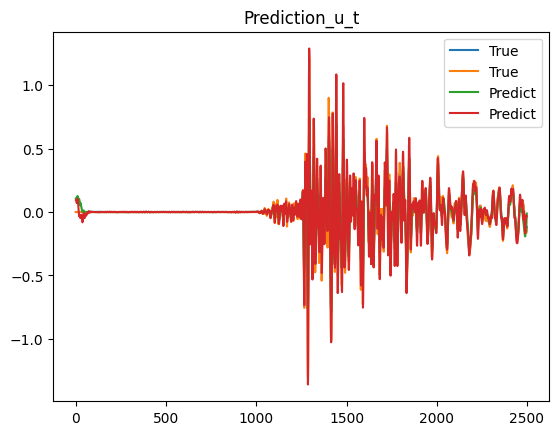

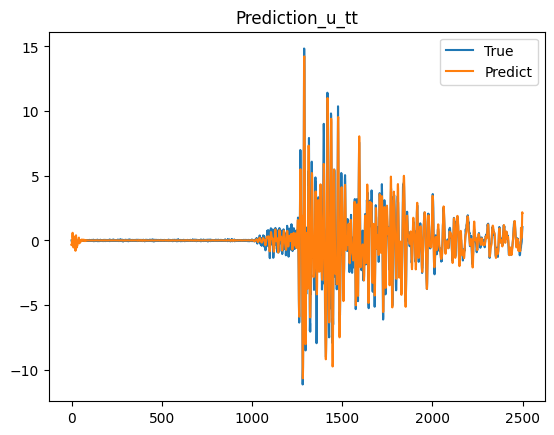

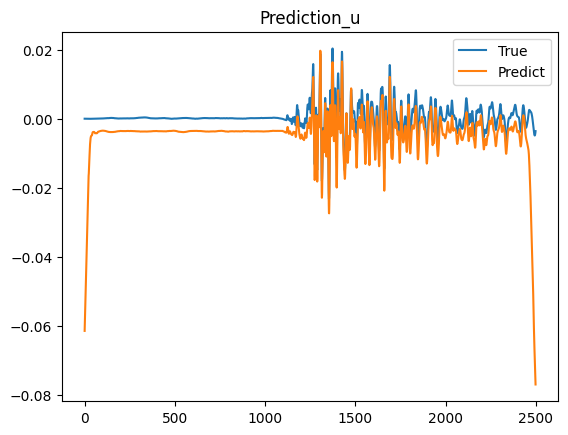

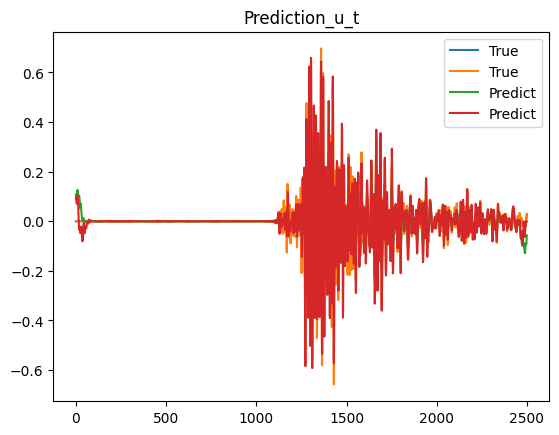

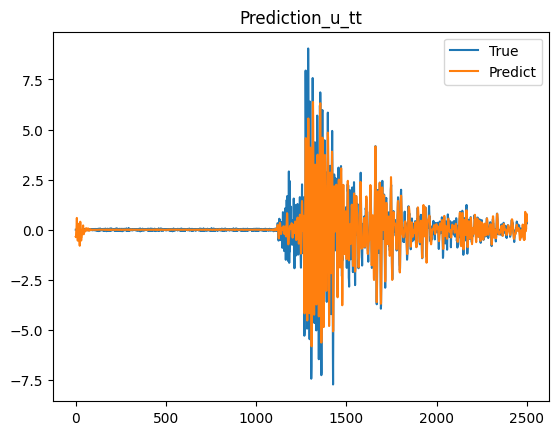

In [35]:
# Prediction performance
ag_pred = mat['input_pred_tf']
u_pred = mat['target_pred_X_tf']
ut_pred = mat['target_pred_Xd_tf']
utt_pred = mat['target_pred_Xdd_tf']
ag_pred = ag_pred.reshape([ag_pred.shape[0], ag_pred.shape[1], 1])

X_pred = np.concatenate([ag_pred, ag_pred, ag_pred[0:3]], axis=0)[:, 0:2500, :]
y_pred_ref = np.concatenate([u_pred, u_pred, u_pred[0:3]], axis=0)[:, 0:2500, :]
yt_pred_ref = np.concatenate([ut_pred, ut_pred, ut_pred[0:3]], axis=0)[:, 0:2500, :]
ytt_pred_ref = np.concatenate([utt_pred, utt_pred, utt_pred[0:3]], axis=0)[:, 0:2500, :]

# Prediction

ag_test_torch = torch.from_numpy(X_pred).float()
ag_test_torch.requires_grad = True

model.eval()

eta_pred = model(ag_test_torch)
Phi_ut = Phi_t.reshape(1, eta_tt.shape[1], eta_tt.shape[1])
Phi_ut = Phi_ut.repeat(eta_tt.shape[0], axis=0)
                
eta_t_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_pred)
eta_tt_pred = torch.matmul(torch.tensor(Phi_ut, dtype=torch.float32), eta_t_pred)

eta_pred = eta_pred.detach().numpy()
eta_t_pred = eta_t_pred.detach().numpy()
eta_tt_pred = eta_tt_pred.detach().numpy()

y_pred = eta_pred
yt_pred = eta_t_pred
ytt_pred = eta_tt_pred

for ii in range(len(y_pred)):
    plt.figure()
    plt.plot(y_pred_ref[ii, :, dof], label='True')
    plt.plot(y_pred[ii, :, dof], label='Predict')
    plt.title('Prediction_u')
    plt.legend()

    plt.figure()
    plt.plot(yt_pred_ref[ii], label='True')
    plt.plot(yt_pred[ii], label='Predict')
    plt.title('Prediction_u_t')
    plt.legend()

    plt.figure()
    plt.plot(ytt_pred_ref[ii, :, dof], label='True')
    plt.plot(ytt_pred[ii, :, dof], label='Predict')
    plt.title('Prediction_u_tt')
    plt.legend()

In [ ]:
R1 = []
R2 = []
R3 = []
for ii in range(len(y_pred_ref)):
    reg1 = LinearRegression().fit(y_pred_ref[ii, :, 0:1], y_pred[ii, :, 0:1])
    R1.append(reg1.coef_)
R = np.concatenate([np.array(R1)])
R = R[:, 0]
plt.hist(R, 'auto', density=True, facecolor='blue', alpha=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram_Model')
ax = plt.gca()
ax.invert_xaxis()

scipy.io.savemat(dataDir + 'results/results_exp_ag2utt.mat',
                {'y_train_ref': y_train_ref, 'yt_train_ref': yt_train_ref, 'ytt_train_ref': ytt_train_ref,
                'y_train_pred': y_train_pred, 'yt_train_pred': yt_train_pred, 'ytt_train_pred': ytt_train_pred,
                'y_pred_ref': y_pred_ref, 'yt_pred_ref': yt_pred_ref, 'ytt_pred_ref': ytt_pred_ref,
                'y_pred': y_pred, 'yt_pred': yt_pred, 'ytt_pred': ytt_pred,
                'X_train': X_train, 'X_pred': X_pred, 'dt': dt,
                'train_loss': train_loss})